In [1]:
import pandas as pd
from pathlib import Path

#mutate(`Test rate` = n_tested / n_windows, 
#`Positive rate` = n_enriched / n_tested, 
#`Enrichment rate` = n_enriched / n_windows)
#enriched_window_transcript_data$pseudocount = enriched_window_transcript_data %>% with(nrow(.) * (n_windows / (sum(n_windows))))
#enriched_window_transcript_data$odds_ratio = enriched_window_transcript_data %>% with((n_enriched + pseudocount) / (sum((n_enriched + pseudocount)) - (n_enriched + pseudocount)) / (n_windows / (sum(n_windows) - n_windows)))
#odds ratio (enrichment_rate /window_rate)
exp_path = Path('/home/hsher/scratch/ABC_2rep_skipper_k562window/')
indir = exp_path / 'output' /'counts' / 'genome' / 'vectors'

all_counts_file = indir.glob('K562_rep4*.counts')
all_counts = []

for count in all_counts_file:
    
    feat_count = pd.read_csv(count, sep = '\t')
        
    all_counts.append(feat_count)

count_df = pd.concat(all_counts, axis = 1)

In [2]:
count_df_copy = count_df.copy()
count_df_copy.index = count_df_copy.index + 1
count_df_copy.to_csv('/home/hsher/scratch/K562_rep4.count.csv')

In [3]:
sum_dist = count_df.sum(axis = 0)
sum_dist = sum_dist/sum_dist.sum()

In [4]:
sum_dist

K562_rep4.ZC3H11A    0.043207
K562_rep4.DDX3       0.051913
K562_rep4.PUM2       0.010079
K562_rep4.LIN28B     0.063352
K562_rep4.IGF2BP2    0.087954
K562_rep4.RBFOX2     0.183719
K562_rep4.PRPF8      0.166768
K562_rep4.EIF3G      0.019947
K562_rep4.FAM120A    0.283656
K562_rep4.SF3B4      0.089407
dtype: float64

In [5]:
count_df = count_df.loc[count_df.sum(axis = 1)>10]

In [6]:
count_df.head()
# shuffle in column
# scale by the number of reads, coeff of variance.

,K562_rep4.ZC3H11A,K562_rep4.DDX3,K562_rep4.PUM2,K562_rep4.LIN28B,K562_rep4.IGF2BP2,K562_rep4.RBFOX2,K562_rep4.PRPF8,K562_rep4.EIF3G,K562_rep4.FAM120A,K562_rep4.SF3B4
0,36,25,9,20,27,38,28,7,44,22
1,36,23,5,24,39,49,42,7,55,32
2,19,21,5,11,34,38,29,3,39,23
3,28,12,3,10,21,31,19,5,35,16
4,8,3,2,3,9,4,7,3,8,3


In [7]:
from scipy.stats import entropy

In [8]:
pseudocount_reads = 10 # push to a uniform prior proportional to sum_dist
pseudocount = pseudocount_reads* sum_dist
# start with the same read to distribute
relative_entropy = count_df.apply(lambda dist: entropy(pk=dist+pseudocount, qk=sum_dist, base = 2),
                                 axis = 1)

In [9]:
relative_entropy.shape

(82241,)

In [10]:
relative_entropy.max()

2.000869916065442

In [11]:
relative_entropy.min()

0.006512110671730696

## Try multinomial

In [12]:
from scipy.stats import multinomial


In [13]:
# is not a cumulative density function
multinomial_logpmf = count_df.apply(lambda row: 
                                    float(multinomial.logpmf(row.values, n = row.sum(), p = sum_dist))
                                    ,
                                 axis = 1)
# probability mass function: the higher, the less suprised it is to observe such counts

In [14]:
from scipy.stats import chisquare
# cannot use when anycount is < 5
chisq_pval = count_df.apply(lambda row: chisquare(f_obs = row, f_exp = sum_dist*row.sum())[1], 
                           axis = 1)

In [15]:
# var by portion
portion_df = count_df.div(count_df.sum(axis = 0), axis = 1)
portion_stderr = portion_df.std(axis = 1)/portion_df.mean(axis = 1)

In [16]:
read_count_per_window = count_df.sum(axis = 1)

In [17]:
annot = '/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz'
annot_df = pd.read_csv(annot, sep = '\t')

In [18]:
data = pd.concat([read_count_per_window, relative_entropy, multinomial_logpmf, chisq_pval, portion_stderr], axis = 1)
data.columns = ['nread', 'relative_entropy', 'multinomial_logpmf', 'chisq_pval', 'stderr']
# data = pd.concat([read_count_per_window, relative_entropy, multinomial_logpmf, portion_stderr], axis = 1)
# data.columns = ['nread', 'relative_entropy', 'multinomial_logpmf', 'stderr']
data.index = count_df.index+1

In [19]:
merged_data = annot_df.merge(data, left_on = 'name', right_index = True)

In [20]:
count_merged = pd.concat([annot_df, count_df], axis = 1)

In [21]:
count_by_type = count_merged.groupby(by = 'feature_type_top')[count_df.columns].sum()

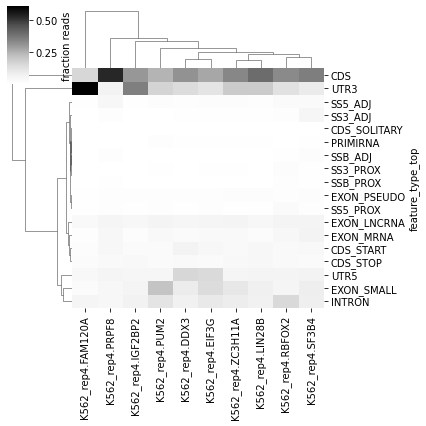

In [22]:
import seaborn as sns
sns.clustermap(count_by_type.div(count_by_type.sum(axis = 0), axis = 1),
              cmap = 'Greys', figsize = (6,6), cbar_kws = {'label': 'fraction reads'})

Text(0, 0.5, '# total reads')

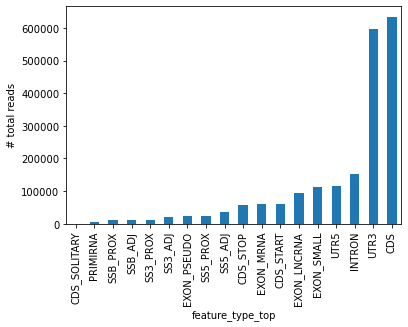

In [23]:
import matplotlib.pyplot as plt
merged_data.groupby(by = 'feature_type_top')['nread'].sum().sort_values().plot.bar()
plt.ylabel('# total reads')

# What are the high entropy windows

<AxesSubplot:>

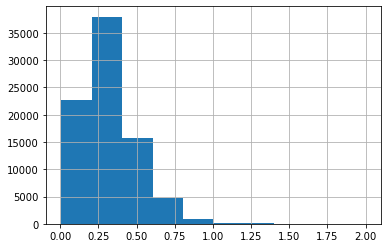

In [24]:
merged_data['relative_entropy'].hist()

<AxesSubplot:>

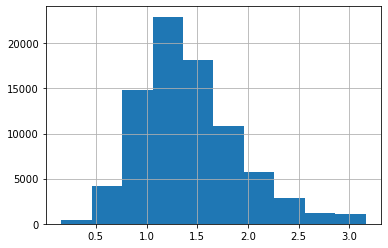

In [25]:
merged_data['stderr'].hist()

<AxesSubplot:>

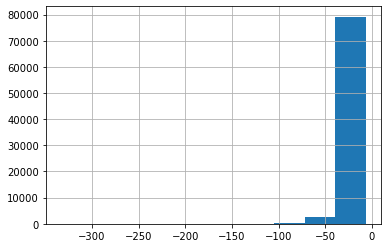

In [26]:
merged_data['multinomial_logpmf'].hist()

<AxesSubplot:>

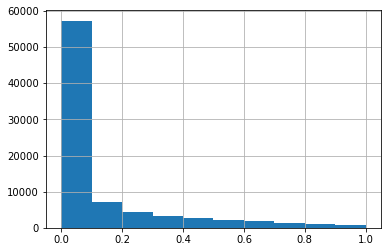

In [27]:
merged_data['chisq_pval'].hist()

In [28]:
def bin_count_type(merged_data, col):
    try:
        merged_data[f'{col}_bins'] = pd.qcut(merged_data[col], q = 10,
                                                  labels = False)
    except:
        merged_data[f'{col}_bins'] = pd.cut(merged_data[col], bins = 10,
                                                  labels = False)
    ftype_count_ri = merged_data.groupby(by = [f'{col}_bins'])['feature_type_top'].value_counts().unstack().fillna(0)
    ftype_frac_ri = ftype_count_ri.div(ftype_count_ri.sum(axis = 1), axis = 0)

    sns.clustermap(ftype_frac_ri, cmap = 'Greys', row_cluster = False, figsize = (5,5), z_score = 1)

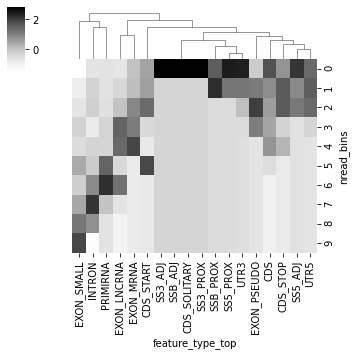

In [29]:
bin_count_type(merged_data, 'nread')

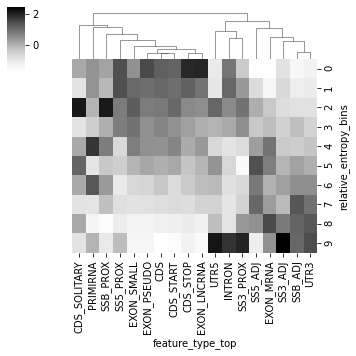

In [30]:
bin_count_type(merged_data, 'relative_entropy')

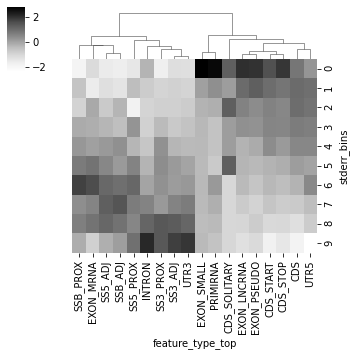

In [31]:
bin_count_type(merged_data, 'stderr')

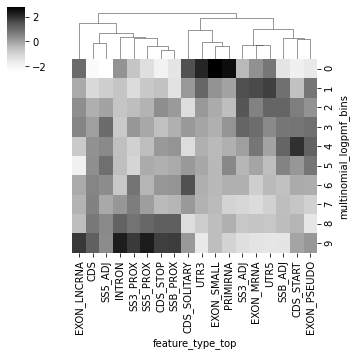

In [32]:
bin_count_type(merged_data, 'multinomial_logpmf')

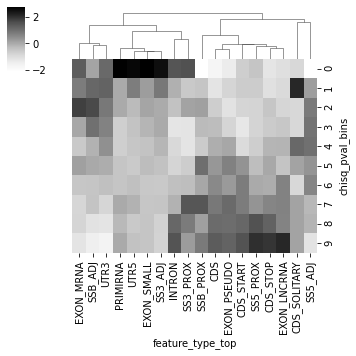

In [33]:
bin_count_type(merged_data, 'chisq_pval')

# relative entropy is more nuanced at low covered regions

<AxesSubplot:xlabel='nread', ylabel='relative_entropy'>

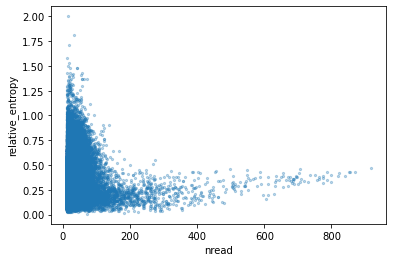

In [34]:
merged_data.plot.scatter(x = 'nread', y = 'relative_entropy', marker = '.', alpha = 0.3)

<AxesSubplot:xlabel='nread', ylabel='stderr'>

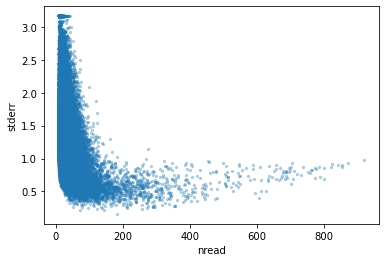

In [35]:
merged_data.plot.scatter(x = 'nread', y = 'stderr', marker = '.', alpha = 0.3)

In [36]:
import random
def permuted_relative_entropy(count_df,total_read, n_iter=1):
    sub_df = count_df.loc[count_df.sum(axis = 1)==total_read]
    
    null_values = []
    for i in range(n_iter):
        shuffled_data = []
        for col in sub_df.columns:
            col_data = sub_df[col].tolist()
            random.shuffle(col_data)
            
            shuffled_data.append(col_data)
        shuffled_data = pd.DataFrame(shuffled_data, index = sub_df.columns).T
        
        null_relative_entropy = shuffled_data.apply(
            lambda dist: entropy(pk=dist+pseudocount, qk=sum_dist, base = 2),
                                 axis = 1)
        null_values+=null_relative_entropy.tolist()
    return null_values
        
        
        

In [44]:
null_ri_by_read_count = {}
for read_count in range(10,200):
    null_ri = permuted_relative_entropy(count_df, read_count)
    null_ri_by_read_count[read_count] = null_ri

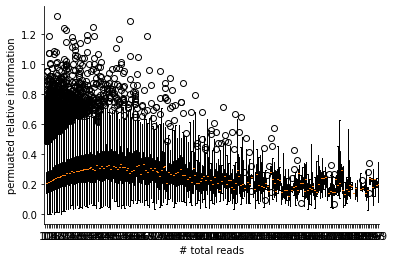

In [45]:
plt.boxplot(null_ri_by_read_count.values())
plt.xticks(list(range(1,len(null_ri_by_read_count)+1)), null_ri_by_read_count.keys())
plt.xlabel('# total reads')
plt.ylabel('permuated relative information')
sns.despine()

In [48]:
import numpy as np
null_ri_stat = []
for read_depth in null_ri_by_read_count:
    try:
        values = null_ri_by_read_count[read_depth]
        null_ri_stat.append([read_depth, 
                             np.mean(values), 
                             np.std(values),
                            np.median(values),
                            np.percentile(values,25),
                            np.percentile(values,75),
                             np.percentile(values,95),
                            max(values),
                            min(values)])
    except Exception as e:
        print(read_depth, len(values), e)
null_ri_stat = pd.DataFrame(null_ri_stat, columns = ['nread', 'mean', 'std',
                                                    'median', '25', '75', '95','max', 'min'])

10 0 index -1 is out of bounds for axis 0 with size 0
188 0 index -1 is out of bounds for axis 0 with size 0


/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [49]:
null_ri_stat.set_index('nread', inplace = True)

In [50]:
null_ri_stat

,mean,std,median,25,75,95,max,min
nread,,,,,,,,
11,0.219544,0.111063,0.203087,0.141092,0.278480,0.424129,0.955084,-8.314919e-18
12,0.228958,0.114304,0.211496,0.148600,0.287305,0.441427,1.185455,-8.314919e-18
13,0.236365,0.116894,0.218622,0.154393,0.296031,0.452241,1.005242,-8.314919e-18
14,0.243884,0.117508,0.224990,0.159780,0.305815,0.461047,0.974927,1.444896e-02
15,0.248639,0.118928,0.230680,0.165360,0.310126,0.462657,1.090491,-8.314919e-18
...,...,...,...,...,...,...,...,...
195,0.230477,0.009823,0.230477,0.225566,0.235389,0.239318,0.240300,2.206546e-01
196,0.180300,0.119177,0.180300,0.120712,0.239888,0.287559,0.299477,6.112332e-02
197,0.193590,0.053252,0.230061,0.174176,0.231239,0.232180,0.232416,1.182915e-01


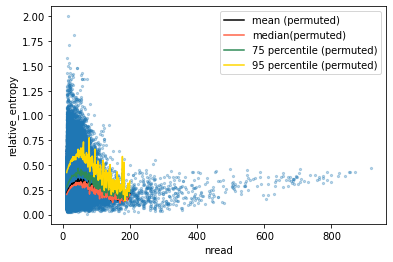

In [51]:
f, ax = plt.subplots()
merged_data.plot.scatter(x = 'nread', y = 'relative_entropy', marker = '.', alpha = 0.3, ax = ax)


null_ri_stat['mean'].plot(ax = ax, color = 'black', label = 'mean (permuted)')
null_ri_stat['median'].plot(ax = ax, color = 'tomato', label = 'median(permuted)')
null_ri_stat['75'].plot(ax = ax, color = 'seagreen', label = '75 percentile (permuted)')
null_ri_stat['95'].plot(ax = ax, color = 'gold', label = '95 percentile (permuted)')
plt.legend()

<AxesSubplot:xlabel='nread', ylabel='multinomial_logpmf'>

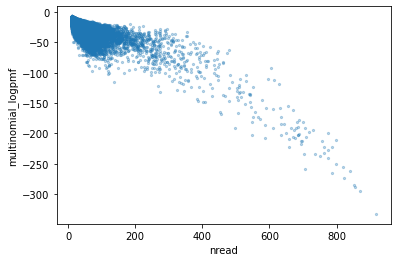

In [52]:
import matplotlib.pyplot as plt
merged_data.plot.scatter(x = 'nread', y = 'multinomial_logpmf', marker = '.', alpha = 0.3)

<AxesSubplot:xlabel='nread', ylabel='chisq_pval'>

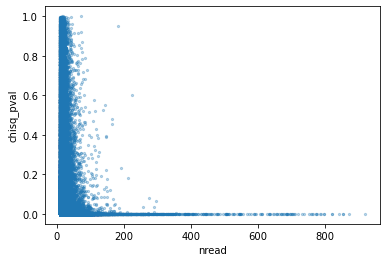

In [53]:
import matplotlib.pyplot as plt
merged_data.plot.scatter(x = 'nread', y = 'chisq_pval', marker = '.', alpha = 0.3)

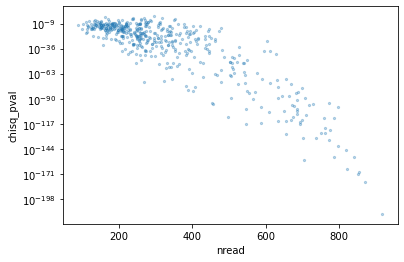

In [54]:
invalid_chi_index = count_df.le(5).any(axis = 1)
merged_data.loc[~invalid_chi_index, :].plot.scatter(x = 'nread', y = 'chisq_pval', marker = '.', alpha = 0.3)
plt.yscale('log')
# empirical shuffling, permutation testing

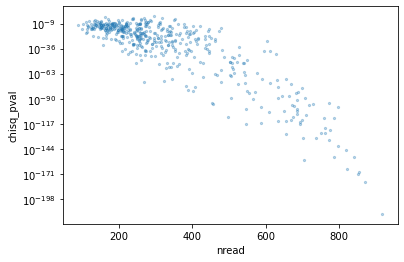

In [55]:
invalid_chi_index = count_df.le(5).any(axis = 1)
merged_data.loc[~invalid_chi_index, :].plot.scatter(x = 'nread', y = 'chisq_pval', marker = '.', alpha = 0.3)
plt.yscale('log')

In [56]:
merged_data['nread_bins'] = pd.qcut(merged_data['nread'], q = 100,
                                              labels = False, duplicates = 'drop')

In [57]:


groups = []
for name, group in merged_data.groupby(by = 'nread_bins'):
    group['ri_bin_percentile'] = group['relative_entropy'].rank(pct = True)
    
    groups.append(group)

merged_data_percentile = pd.concat(groups, axis = 0)

In [58]:
merged_data_percentile.head()

,chrom,start,end,name,score,strand,feature_id,feature_bin,feature_type_top,feature_types,...,relative_entropy,multinomial_logpmf,chisq_pval,stderr,nread_bins,relative_entropy_bins,stderr_bins,multinomial_logpmf_bins,chisq_pval_bins,ri_bin_percentile
358,chr1,961292,961378,359,0,+,47,1,CDS,CDS:EXON_MRNA:INTRON,...,0.272338,-12.760139,0.044645,1.481312,0,4,6,7,6,0.555483
366,chr1,961899,961973,367,0,+,51,2,CDS,CDS:EXON_MRNA:SS3_PROX:INTRON,...,0.177693,-11.224300,0.156007,1.326546,0,1,4,8,7,0.249334
368,chr1,962047,962081,369,0,+,52,1,EXON_MRNA,EXON_MRNA:SS3_ADJ:SS5_ADJ:SSB_PROX:SS3_PROX:SS...,...,0.278825,-12.569731,0.052358,1.394510,0,4,5,7,6,0.577665
380,chr1,962806,962861,381,0,+,61,1,CDS,CDS:EXON_MRNA,...,0.144506,-8.423503,0.540407,1.530717,0,1,6,9,9,0.145871
387,chr1,963179,963253,388,0,+,65,3,CDS,CDS:EXON_MRNA,...,0.262098,-13.174402,0.067579,1.295449,0,4,4,6,6,0.526450


<AxesSubplot:xlabel='nread', ylabel='ri_bin_percentile'>

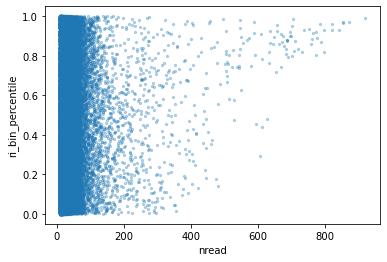

In [59]:
merged_data_percentile.plot.scatter(x = 'nread', y = 'ri_bin_percentile', marker = '.', alpha = 0.3)

In [60]:
merged_data_percentile['ri_perc_bins'] = pd.qcut(merged_data_percentile['ri_bin_percentile'], q = 10,
                                              labels = False)

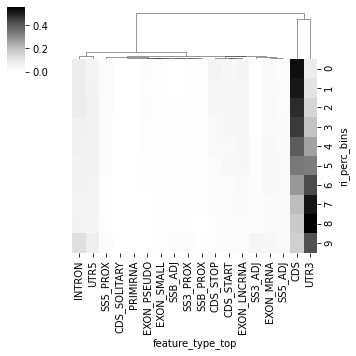

In [61]:
ftype_count_ri = merged_data_percentile.groupby(by = ['ri_perc_bins'])['feature_type_top'].value_counts().unstack().fillna(0)
ftype_frac_ri = ftype_count_ri.div(ftype_count_ri.sum(axis = 1), axis = 0)
import seaborn as sns
sns.clustermap(ftype_frac_ri, cmap = 'Greys', row_cluster = False, figsize = (5,5))

# Test threshold by ri

In [62]:
import pandas as pd
test_data = pd.read_csv('K562_rep4.DDX3.pval.tsv', sep = '\t')

In [63]:
test_data.shape

(1450785, 17)

In [64]:
test_data['relative_entropy'] = test_data['name'].map(merged_data_percentile['relative_entropy'])
test_data['ri_bin_percentile'] = test_data['name'].map(merged_data_percentile['ri_bin_percentile'])
test_data['multinomial_logpmf'] = test_data['name'].map(merged_data_percentile['multinomial_logpmf'])
test_data['chisq_pval'] = test_data['name'].map(merged_data_percentile['chisq_pval'])
test_data['nread'] = test_data['name'].map(merged_data_percentile['nread'])
test_data['stderr'] = test_data['name'].map(merged_data_percentile['stderr'])

In [65]:
old_output = pd.read_csv('Dan_multiplex1_K562_rep4.Dan_multiplex1_K562_rep6.reproducible_window.csv')
test_data = test_data.merge(old_output, left_on = 'name', right_on = 'name', how = 'left')
test_data[old_output.columns] = test_data[old_output.columns].fillna(False)

<AxesSubplot:>

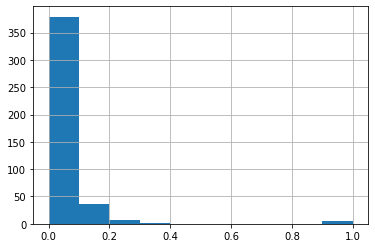

In [68]:
# the ground truth windows has good pvalue
test_data.loc[test_data['DDX3'],'pvalue'].hist()

In [67]:
test_data.loc[test_data['DDX3'], 'feature_type_top'].value_counts() # validating

UTR5            273
CDS_START        94
CDS              52
EXON_LNCRNA       7
CDS_SOLITARY      1
EXON_MRNA         1
SS3_PROX          1
INTRON            1
Name: feature_type_top, dtype: int64

# Do any of the stats distiguish the ground truth from others

In [73]:
test_data['bound_by_any'] = test_data[old_output.columns[1:]].any(axis = 1)

<AxesSubplot:xlabel='Proportion', ylabel='relative_entropy'>

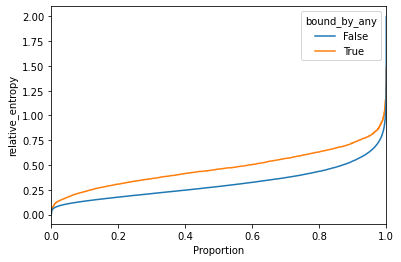

In [75]:
sns.ecdfplot(data = test_data, hue = 'bound_by_any', y = 'relative_entropy')

<AxesSubplot:xlabel='Proportion', ylabel='ri_bin_percentile'>

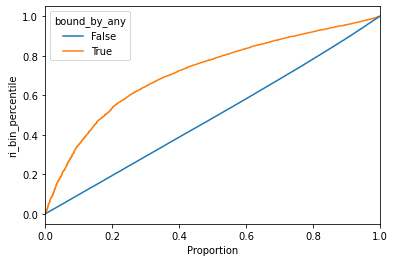

In [76]:
sns.ecdfplot(data = test_data, hue = 'bound_by_any', y = 'ri_bin_percentile')

<AxesSubplot:xlabel='Proportion', ylabel='stderr'>

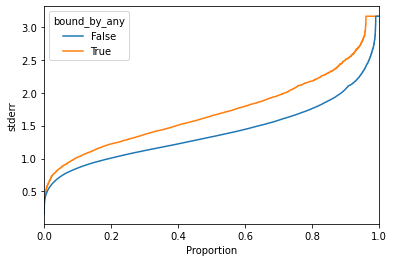

In [77]:
sns.ecdfplot(data = test_data, hue = 'bound_by_any', y = 'stderr')

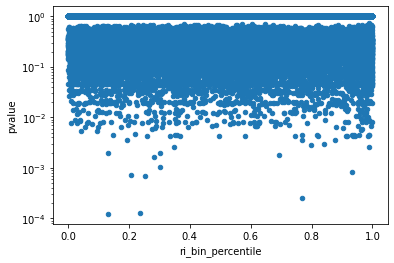

In [80]:
test_data.plot.scatter(x = 'ri_bin_percentile', y = 'pvalue')
plt.yscale('log')

In [83]:
from statsmodels.stats.multitest import fdrcorrection
def fdr_ranking_procedure(test_data, column, alpha = 0.2):
    test_data['col_bins'] = pd.cut(test_data[column], bins = 10, labels = False)
    
    max_bin = test_data['col_bins'].max()
    min_bin = test_data['col_bins'].min()
    
    threshold_data = []
    
    for thres in range(int(max_bin), int(min_bin), -1):
        to_test = test_data.loc[test_data['col_bins']>thres]
        
        _, fdr = fdrcorrection(to_test['pvalue'], alpha = alpha)
        
        threshold_data.append([thres, sum(fdr<alpha)])
        
    return pd.DataFrame(threshold_data, columns = ['threshold', 'n_enriched'])
        
        

In [85]:
_, fdr = fdrcorrection(test_data.loc[test_data['d_log_odds']>1, 'pvalue'], alpha = 0.2)
sum(fdr<0.2)

104571

In [97]:
_, fdr = fdrcorrection(test_data.loc[test_data['bound_by_any'], 'pvalue'], alpha = 0.2)
sum(fdr<0.2)

0

<AxesSubplot:>

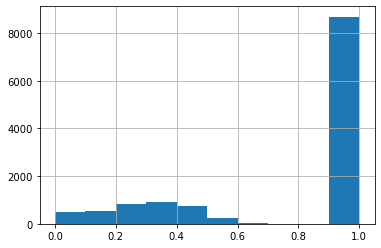

In [99]:
test_data.loc[test_data['bound_by_any'], 'pvalue'].hist()

<AxesSubplot:>

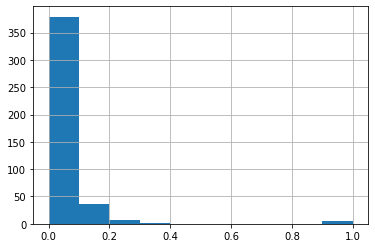

In [100]:
test_data.loc[test_data['DDX3'], 'pvalue'].hist()

<AxesSubplot:xlabel='threshold'>

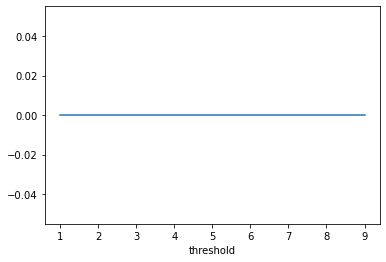

In [86]:
ri_thres = fdr_ranking_procedure(test_data, 'ri_bin_percentile')
ri_thres.set_index('threshold')['n_enriched'].plot()

<AxesSubplot:xlabel='threshold'>

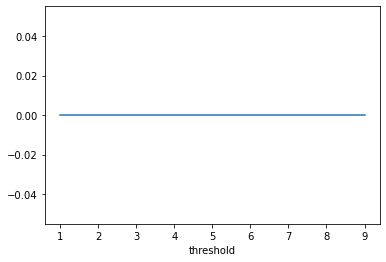

In [87]:
ri_thres = fdr_ranking_procedure(test_data, 'relative_entropy')
ri_thres.set_index('threshold')['n_enriched'].plot()

<AxesSubplot:xlabel='threshold'>

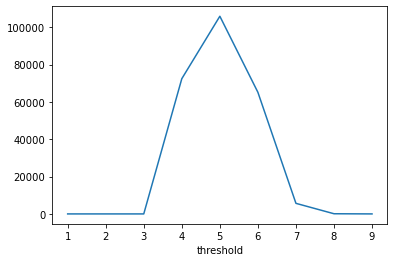

In [88]:
ri_thres = fdr_ranking_procedure(test_data, 'd_log_odds')
ri_thres.set_index('threshold')['n_enriched'].plot()

<AxesSubplot:xlabel='threshold'>

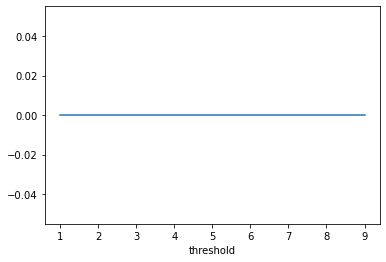

In [89]:
ri_thres = fdr_ranking_procedure(test_data, 'stderr')
ri_thres.set_index('threshold')['n_enriched'].plot()

Text(0.5, 0, '#')

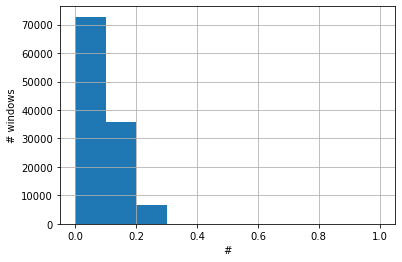

In [90]:
test_data.loc[test_data['d_log_odds']>1, 'pvalue'].hist(range = (0,1))
plt.ylabel('# windows')
plt.xlabel('#')

In [91]:
test_data_w_stat = test_data.merge(null_ri_stat, left_on = 'nread', right_index = True).fillna(0)

0
0.8353395616241466


<AxesSubplot:>

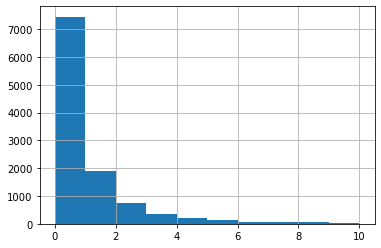

In [92]:


sub = test_data_w_stat.loc[test_data_w_stat['relative_entropy']>test_data_w_stat['95']]
rejected, fdr = fdrcorrection(sub['pvalue'], alpha = 0.2)
print(rejected.sum())
print(sub['clip'].mean())
sub['clip'].hist(range = (0,10))

0
0.7506714972827785


<AxesSubplot:>

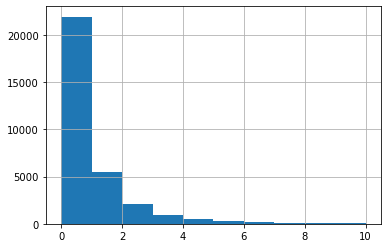

In [93]:

sub = test_data_w_stat.loc[(test_data_w_stat['relative_entropy']>test_data_w_stat['75'])]
rejected, fdr = fdrcorrection(sub['pvalue'], alpha = 0.2)
print(rejected.sum())
print(sub['clip'].mean())
sub['clip'].hist(range = (0,10))

0
0.7690551972527012


<AxesSubplot:>

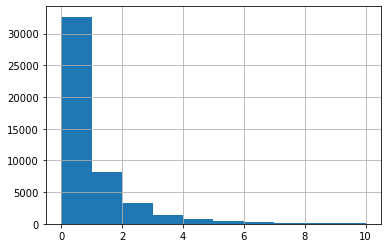

In [94]:

sub = test_data_w_stat.loc[test_data_w_stat['relative_entropy']>test_data_w_stat['median']]
rejected, fdr = fdrcorrection(sub['pvalue'], alpha = 0.2)
print(rejected.sum())
print(sub['clip'].mean())
sub['clip'].hist(range = (0,10))

0
0.0


<AxesSubplot:>

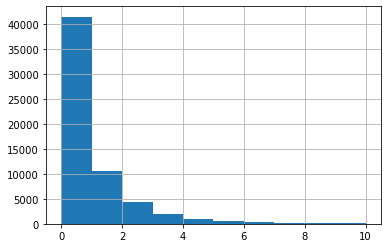

In [95]:

sub = test_data_w_stat.loc[test_data_w_stat['relative_entropy']>test_data_w_stat['25']]
rejected, fdr = fdrcorrection(sub['pvalue'], alpha = 0.2)
print(rejected.sum())
print(sub['clip'].median())
sub['clip'].hist(range = (0,10))

In [96]:
sub['pvalue'].min()

0.0001308275468069331

In [ ]:
entropy([5,5,5], [10,10,10])

In [ ]:
entropy([5,6,4], [10,10,10])

In [ ]:
entropy([0,15,0], [10,10,10])

In [ ]:
entropy([5,5,5], [10,20,30])

In [ ]:
entropy([30,20,10], [10,20,30])

In [ ]:
entropy([60,0,0], [10,20,30])

In [ ]:
test_data['clip'].hist(range = (0,10))

In [ ]:
test_data.loc[test_data['d_log_odds']>0, 'pvalue'].hist()
plt.title('filter by d_log_odds read > 0')
plt.ylabel('#windows')
plt.xlabel('#p-value')

In [ ]:

sub = test_data.loc[test_data['clip']>0]
rejected, fdr = fdrcorrection(sub['pvalue'], alpha = 0.2)
print(rejected.sum())
print(sub['clip'].median())
sub['clip'].hist(range = (0,10))
sub['feature_type_top'].value_counts()

In [ ]:

sub = test_data.loc[test_data['feature_type_top']!='EXON_SMALL']
rejected, fdr = fdrcorrection(sub['pvalue'], alpha = 0.2)
print(rejected.sum())
print(sub['clip'].median())
sub['clip'].hist(range = (0,10))

In [ ]:

sub = test_data_w_stat.loc[test_data_w_stat['feature_type_top']=='INTRON']
rejected, fdr = fdrcorrection(sub['pvalue'], alpha = 0.2)
print(rejected.sum())
print(sub['clip'].median())
sub['clip'].hist(range = (0,10))

In [ ]:
sub.shape